In [35]:
import torch
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from model.ensemble import EnsembleModel
from model.common import CommonPLModuleWrapper
from sklearn.metrics import confusion_matrix
from monai.losses import DiceLoss
from monai.networks.nets import UNETR, SegResNet
from monai.networks.utils import one_hot
import pandas as pd


from dataloader import BrainTumourDataModule

In [36]:
IMAGE_PATH = "../data/BrainTumourData/imagesTr/"
LABEL_PATH = "../data/BrainTumourData/labelsTr/"
IMG_SIZE = 128
BATCH_SIZE = 1
IN_CHANNELS = 4
OUT_CHANNELS = 4

In [37]:
data_module = BrainTumourDataModule(
    data_path=IMAGE_PATH,
    seg_path=LABEL_PATH,
    img_dim=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
data_module.prepare_data()
data_module.setup()

In [38]:
segresnet = CommonPLModuleWrapper(
    model=SegResNet(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS),
    loss_fn=DiceLoss(softmax=True),
)
segres_weights = torch.load(
    f"../model/{segresnet.model.__class__.__name__}.ckpt", weights_only=True
)
segresnet.load_state_dict(segres_weights["state_dict"])

unet = CommonPLModuleWrapper(
    model=UNETR(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        img_size=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    ),
    loss_fn=DiceLoss(softmax=True),
)
unet_weights = torch.load(
    f"../model/{unet.model.__class__.__name__}.ckpt", weights_only=True
)
unet.load_state_dict(unet_weights["state_dict"])

model = EnsembleModel([segresnet, unet], num_classes=4)

In [39]:
model.eval()

total_batches = len(data_module.test_dataloader())
num_classes = 4
height, width = 128, 128
slices_per_sample = 128

all_predictions = torch.empty(
    (total_batches, num_classes, slices_per_sample, height, width), dtype=torch.float32
)
all_targets = torch.empty(
    (total_batches, num_classes, slices_per_sample, height, width), dtype=torch.float32
)

for current_index, (images, targets) in enumerate(data_module.test_dataloader()):
    with torch.no_grad():
        predictions = model(images)
        all_predictions[current_index] = predictions[0]
        all_targets[current_index] = targets[0]

all_predictions = torch.argmax(all_predictions, dim=1)
all_predictions = one_hot(all_predictions.unsqueeze(1), num_classes)

In [40]:
from monai.metrics import (
    compute_confusion_matrix_metric,
    get_confusion_matrix,
    compute_dice,
)

dice_metric = compute_dice(
    y_pred=all_predictions, y=all_targets, ignore_empty=False, num_classes=4
)
mean_dice = dice_metric.mean(dim=0)
print(f"Dice Coefficient: {mean_dice}")
print(f"Mean Dice Coefficient: {mean_dice.mean()}")

Dice Coefficient: tensor([0.9983, 0.7614, 0.5068, 0.7581])
Mean Dice Coefficient: 0.7561590671539307


In [41]:
index_to_name = {
    0: "Background",
    1: "Edema",
    2: "Non-Enhancing Tumor",
    3: "Enhancing Tumor",
}

predicted_classes = torch.argmax(all_predictions, dim=1).flatten().cpu().numpy()
target_classes = torch.argmax(all_targets, dim=1).flatten().cpu().numpy()
conf_matrix = confusion_matrix(target_classes, predicted_classes)

df = pd.DataFrame(
    conf_matrix, columns=index_to_name.values(), index=index_to_name.values()
)
print(df)

                     Background   Edema  Non-Enhancing Tumor  Enhancing Tumor
Background            121621977  162328                 8809             8543
Edema                    172758  992667                72317            11855
Non-Enhancing Tumor       27951   67165               176307            34232
Enhancing Tumor           24168   19820                28726           302345


In [42]:
confusion_matrix = get_confusion_matrix(
    y_pred=all_predictions, y=all_targets, include_background=False
)
cm = confusion_matrix.sum(dim=0)
print(f"Confusion Matrix: \n{cm}")

recall = compute_confusion_matrix_metric(
    confusion_matrix=cm,
    metric_name="sensitivity",
)
print(f"Recall: {recall}")

alpha = torch.tensor([0.2, 0.3, 0.5])
weighted_recall = (recall * alpha).sum()
print(f"Weighted Recall: {weighted_recall}")

precision = compute_confusion_matrix_metric(
    confusion_matrix=cm,
    metric_name="precision",
)
print(f"Precision: {precision}")

Confusion Matrix: 
tensor([[9.9267e+05, 2.4931e+05, 1.2223e+08, 2.5693e+05],
        [1.7631e+05, 1.0985e+05, 1.2332e+08, 1.2935e+05],
        [3.0234e+05, 5.4630e+04, 1.2330e+08, 7.2714e+04]])
Recall: tensor([0.7944, 0.5768, 0.8061])
Weighted Recall: 0.7349863052368164
Precision: tensor([0.7993, 0.6161, 0.8470])


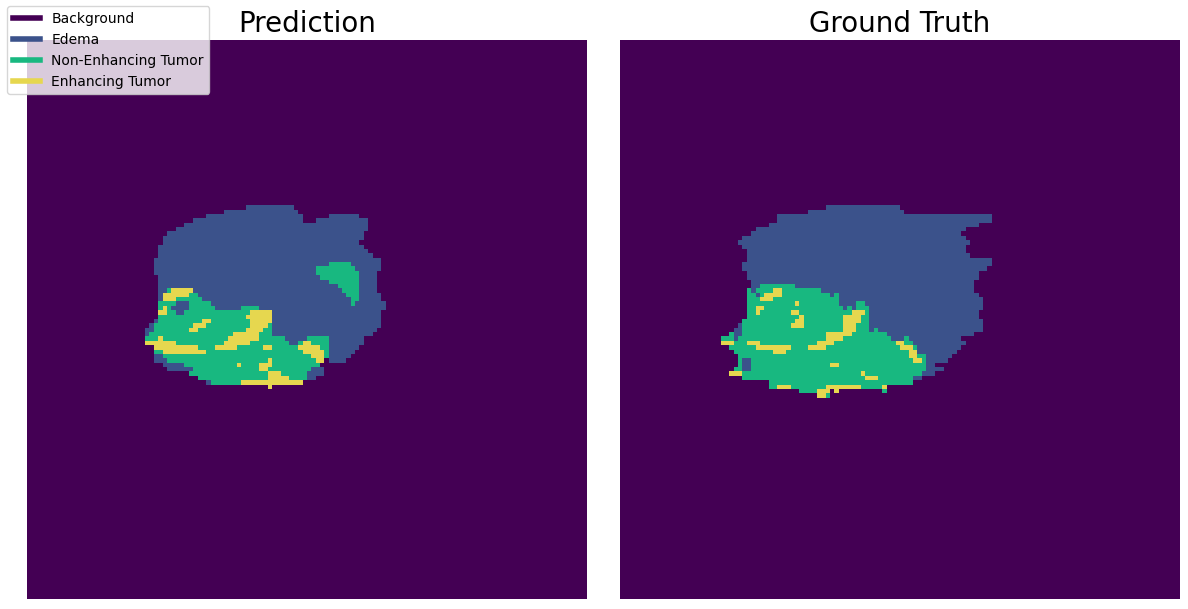

In [43]:
import matplotlib.pyplot as plt

slice = 40
example = 15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

index_to_name = {
    0: "Background",
    1: "Edema",
    2: "Non-Enhancing Tumor",
    3: "Enhancing Tumor",
}

colors = {
    0: [68, 0, 84],  # Background - #440054
    1: [59, 82, 139],  # Edema - #3b528b
    2: [24, 184, 128],  # Non-enhancing Tumor - #18b880
    3: [230, 215, 79],  # Enhancing Tumor - #e6d74f
}

# Normalize colors to [0, 1] range for matplotlib
colors = {k: [c / 255.0 for c in v] for k, v in colors.items()}

# Create a colormap
cmap = plt.cm.colors.ListedColormap([colors[i] for i in range(4)])

# Plot predictions
axs[0].imshow(all_predictions[example, :, slice, :, :].argmax(axis=0), cmap=cmap)
axs[0].set_title("Prediction", fontsize=20)
axs[0].axis("off")

# Plot ground truth
axs[1].imshow(all_targets[example, :, slice, :, :].argmax(axis=0), cmap=cmap)
axs[1].set_title("Ground Truth", fontsize=20)
axs[1].axis("off")

# Create legend
handles = [plt.Line2D([0], [0], color=tuple(color), lw=4) for color in colors.values()]
labels = [index_to_name[i] for i in range(4)]
fig.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()